In [6]:
import torch
from tensordict.tensordict import TensorDict
from collections import defaultdict
from functools import partial
from pathlib import Path
import shutil
import sys
import time
from typing import Any, Dict, Optional, Tuple, OrderedDict
import random
import hydra
from hydra.utils import instantiate
from hydra.utils import get_original_cwd, to_absolute_path
from omegaconf import DictConfig, OmegaConf, open_dict
from torch.utils.tensorboard import SummaryWriter
from collections import deque
from tqdm import tqdm
import wandb
import ray

import envpool
# import gymnasium as gym
import gym
from gym.spaces import Box, Discrete
from gym.spaces.dict import Dict as GymDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.func
from modules.agent import Agent
from modules.utils import set_seed, make_batched_env
                            

In [7]:
from omegaconf import OmegaConf

cfg_path = "/home/kukjin/Projects/DARL_transformer/configs/ppo_trainer.yaml"
nn_cfg_path = "/home/kukjin/Projects/DARL_transformer/configs/nn/nn.yaml"
ppo_cfg_path = "/home/kukjin/Projects/DARL_transformer/configs/ppo/ppo.yaml"
ccnn_cfg_img_path = "/home/kukjin/Projects/DARL_transformer/configs/ccnn_img/ccnn_img.yaml"
ccnn_cfg_seq_path = "/home/kukjin/Projects/DARL_transformer/configs/ccnn_seq/ccnn_seq.yaml"

cfg = OmegaConf.load(cfg_path)
nn_cfg = OmegaConf.load(nn_cfg_path)
ppo_cfg = OmegaConf.load(ppo_cfg_path)
ccnn_seq_cfg = OmegaConf.load(ccnn_cfg_img_path)
ccnn_img_cfg = OmegaConf.load(ccnn_cfg_seq_path)

cfg.nn = nn_cfg
cfg.ppo = ppo_cfg
cfg.ccnn_seq = ccnn_seq_cfg
cfg.ccnn_img = ccnn_img_cfg

cfg

{'defaults': [{'ppo': 'ppo'}, {'nn': 'nn'}, {'ccnn_img': 'ccnn_img'}, {'ccnn_seq': 'ccnn_seq'}, '_self_'], 'hydra': {'run': {'dir': 'outputs/${now:%Y-%m-%d/%H-%M-%S}'}}, 'experiment': {'seed': 42, 'max_episode_steps': 1000, 'num_rollout_steps': 2048, 'num_envs': 32, 'total_timesteps': 10000000, 'save_ckpt': False, 'num_checkpoints': 20, 'print_interval': 100, 'stop_after_epochs': 500, 'capture_video': False, 'device': 4, 'cuda': True, 'torch_deterministic': True, 'resume': False, 'resume_update_idx': 0, 'resume_dir': 'None', 'env_ids': ['CartPole-v1', 'Pendulum-v1', 'Acrobot-v1', 'BipedalWalker-v3', 'LunarLander-v2', 'HalfCheetah-v4', 'Ant-v4', 'Hopper-v4', 'Walker2d-v4']}, 'evaluation': {'eval_seed': 3142, 'every': 2, 'num_eval': 5, 'num_test_envs': 5}, 'wandb': {'mode': 'online', 'project': 'DomainAgnosticRL', 'entity': None, 'name': None, 'group': None, 'tags': None, 'notes': None}, 'paths': {'dir': 'outputs/${now:%Y-%m-%d/%H-%M-%S}', 'log': 'outputs/${now:%Y-%m-%d/%H-%M-%S}/runs', 

In [8]:
agent = Agent(cfg)

15
6
4
15
6
4


In [ ]:
def load_checkpoint(self) -> None:
    exp_cfg = self.cfg.experiment
    ckpt_str = exp_cfg.resume_dir + '/checkpoints/' + str(exp_cfg.resume_update_idx)
    ckpt_dir = Path(ckpt_str)
    self.start_update_idx = torch.load(ckpt_dir / 'epoch.pt') + 1
    agent_state_dict = torch.load(ckpt_dir / 'agent.pt', map_location=self.device)
    self.agent.load_state_dict(agent_state_dict['agent'])
    # ckpt_opt = torch.load(ckpt_dir / 'optimizer.pt', map_location=self.device)
    # self.agent_optimizer.load_state_dict(ckpt_opt['agent_optimizer'])
    # logger.info(f'Successfully loaded models, optimizers from {ckpt_dir}.')
    

In [ ]:
device = 'cuda:4'

In [12]:
ckpt_dir = "/home/kukjin/Projects/DARL_transformer/outputs/2023-08-23/21-32-11/checkpoints/152/agent.pt"
agent_state_dict = torch.load(ckpt_dir, map_location=device)
agent.load_state_dict(agent_state_dict['agent'])

<All keys matched successfully>

In [13]:
env_ids = ['CartPole-v1',
 'Pendulum-v1',
 'Acrobot-v1',
  'BipedalWalker-v3',
 'LunarLander-v2',
  'HalfCheetah-v4',
  'Ant-v4',
 'Hopper-v4',
  'Walker2d-v4',]
train_different_envs = []
for j, env_id in enumerate(env_ids):
    train_envs = make_batched_env(j, env_id, cfg, mode='train')
    train_different_envs.append(train_envs)
    print(f"{j+1}/{len(env_ids)}environment {env_id} is loaded...")


Train env 1: CartPole-v1 is loaded
1/9environment CartPole-v1 is loaded...
Train env 2: Pendulum-v1 is loaded
2/9environment Pendulum-v1 is loaded...
Train env 3: Acrobot-v1 is loaded
3/9environment Acrobot-v1 is loaded...
Train env 4: BipedalWalker-v3 is loaded
4/9environment BipedalWalker-v3 is loaded...
Train env 5: LunarLander-v2 is loaded
5/9environment LunarLander-v2 is loaded...


/mnt/harddisk1/anaconda3/envs/darl2/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/mnt/harddisk1/anaconda3/envs/darl2/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Train env 6: HalfCheetah-v4 is loaded
6/9environment HalfCheetah-v4 is loaded...
Train env 7: Ant-v4 is loaded
7/9environment Ant-v4 is loaded...
Train env 8: Hopper-v4 is loaded
8/9environment Hopper-v4 is loaded...
Train env 9: Walker2d-v4 is loaded
9/9environment Walker2d-v4 is loaded...


In [26]:
envs_storages = TensorDict({}, batch_size=[2048, 32])
for i, envs in enumerate(train_different_envs):
    env_id = env_ids[i]
    obs = torch.zeros((2048, 32) \
        + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((2048, 32) \
        + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((2048, 32)).to(device)
    rewards = torch.zeros((2048, 32)).to(device)
    dones = torch.zeros((2048, 32)).to(device)
    values = torch.zeros((2048, 32)).to(device)
    storage = TensorDict({
                "obs": obs,
                "actions": actions,
                "logprobs": logprobs,
                "rewards": rewards,
                "dones": dones,
                "values": values
                }, batch_size=[2048, 32])
    envs_storages[env_id] = storage

In [27]:
next_obs_dict = TensorDict({}, batch_size=cfg.experiment.num_envs)
next_done_dict = TensorDict({}, batch_size=cfg.experiment.num_envs)
for i, envs in enumerate(train_different_envs):
    env_id = env_ids[i]
    next_obs = envs.reset()
    next_obs = torch.Tensor(next_obs).to(device)
    next_done = torch.zeros(cfg.experiment.num_envs).to(device)
    next_obs_dict[env_id] = next_obs
    next_done_dict[env_id] = next_done

In [29]:
envs_returns = dict()
envs_lengths = dict()
for i, envs in enumerate(train_different_envs):
    env_id = env_ids[i]
    print(env_id)
    for step in range(0, cfg.experiment.num_rollout_steps):
        envs_storages[env_id]["obs"][step] = next_obs_dict[env_id]
        envs_storages[env_id]["dones"][step] = next_done_dict[env_id]

        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(envs.single_action_space, next_obs_dict[env_id])

        envs_storages[env_id]["values"][step] = value.flatten()
        envs_storages[env_id]["actions"][step] = action
        envs_storages[env_id]["logprobs"][step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, done, infos = envs.step(action.cpu().numpy())
        envs_storages[env_id]["rewards"][step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        next_obs_dict[env_id] = next_obs
        next_done_dict[env_id] = next_done
            
        for k, d in enumerate(done):
            if d:
                # logger.info(f"[{update_idx}/{total_num_updates}] Train. env_name:{env_ids[i]}, global_step={global_step}, episodic_return={infos['r'][k]}")
                envs_returns[env_id+'/train'] = infos["r"][k]
                envs_lengths[env_id+'/train'] = infos["l"][k]

In [ ]:
# 한 번 롤아웃하는데 15분 정도 걸림
# env_returns = {'CartPole-v1/train': 67.0,
#  'Pendulum-v1/train': -1153.3905,
#  'Acrobot-v1/train': -96.0,
#  'BipedalWalker-v3/train': -11.827243,
#  'LunarLander-v2/train': -529.5109,
#  'HalfCheetah-v4/train': 1934.849,
#  'Ant-v4/train': 1185.3798,
#  'Hopper-v4/train': 275.2689,
#  'Walker2d-v4/train': 444.75598}

In [35]:
envs_returns = dict()
envs_lengths = dict()
for i, envs in enumerate(train_different_envs):
    env_id = env_ids[i]
    print(env_id)
    is_break = False
    for step in range(0, cfg.experiment.num_rollout_steps):
        envs_storages[env_id]["obs"][step] = next_obs_dict[env_id]
        envs_storages[env_id]["dones"][step] = next_done_dict[env_id]

        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(envs.single_action_space, next_obs_dict[env_id])

        envs_storages[env_id]["values"][step] = value.flatten()
        envs_storages[env_id]["actions"][step] = action
        envs_storages[env_id]["logprobs"][step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, done, infos = envs.step(action.cpu().numpy())
        envs_storages[env_id]["rewards"][step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        next_obs_dict[env_id] = next_obs
        next_done_dict[env_id] = next_done
            
        for k, d in enumerate(done):
            if d:
                # logger.info(f"[{update_idx}/{total_num_updates}] Train. env_name:{env_ids[i]}, global_step={global_step}, episodic_return={infos['r'][k]}")
                envs_returns[env_id+'/train'] = infos["r"][k]
                envs_lengths[env_id+'/train'] = infos["l"][k]
                is_break = True
        if is_break:
            break

CartPole-v1
Pendulum-v1
Acrobot-v1
BipedalWalker-v3
LunarLander-v2
HalfCheetah-v4
Ant-v4
Hopper-v4
Walker2d-v4


In [36]:
envs_returns

{'CartPole-v1/train': 13.0,
 'Pendulum-v1/train': -1199.486,
 'Acrobot-v1/train': -111.0,
 'BipedalWalker-v3/train': -8.393649,
 'LunarLander-v2/train': -137.25848,
 'HalfCheetah-v4/train': 1733.8254,
 'Ant-v4/train': 1559.7185,
 'Hopper-v4/train': 359.4944,
 'Walker2d-v4/train': 525.34174}

In [34]:
envs_storages


TensorDict(
    fields={
        Acrobot-v1: TensorDict(
            fields={
                actions: Tensor(shape=torch.Size([2048, 32]), device=cpu, dtype=torch.float32, is_shared=False),
                dones: Tensor(shape=torch.Size([2048, 32]), device=cpu, dtype=torch.float32, is_shared=False),
                logprobs: Tensor(shape=torch.Size([2048, 32]), device=cpu, dtype=torch.float32, is_shared=False),
                obs: Tensor(shape=torch.Size([2048, 32, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                rewards: Tensor(shape=torch.Size([2048, 32]), device=cpu, dtype=torch.float32, is_shared=False),
                values: Tensor(shape=torch.Size([2048, 32]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([2048, 32]),
            device=None,
            is_shared=False),
        Ant-v4: TensorDict(
            fields={
                actions: Tensor(shape=torch.Size([2048, 32, 8]), device=cpu, dtype=torch.float3

In [37]:
step = 0
env_id = 'HalfCheetah-v4'
obs =  envs_storages[env_id]["obs"][step]
h1 = agent.actor.obs_encoder_1d(obs)

In [169]:
step = 100
h_list = []
h2_list = []
h_ids = []
for i, env_id in enumerate(env_ids):
    obs =  envs_storages[env_id]["obs"][step]
    h = agent.actor.obs_encoder_1d(obs)
    h = torch.tanh(h)
    h2 = agent.actor.res_mlp(h)
    h2 = torch.tanh(h2)
    
    # h = h[0]
    h = h.mean(1, keepdim=False)
    h_list.append(h)
    h2 = h2.mean(1, keepdim=False)
    h2_list.append(h)
    # h = h.view(-1)
    h_ids.append([i for j in range(32)])

In [170]:
h_list

[tensor([[ 0.0517,  0.1780, -0.3957,  ..., -0.4723,  0.0366,  0.0726],
         [-0.0208,  0.1089,  0.0606,  ..., -0.4082, -0.1452,  0.0962],
         [-0.1900, -0.0439,  0.0514,  ...,  0.3115, -0.1348, -0.0900],
         ...,
         [ 0.1197,  0.1782, -0.0234,  ...,  0.0717, -0.3307, -0.2655],
         [-0.2393, -0.0705,  0.1414,  ..., -0.0609, -0.2122, -0.1169],
         [ 0.0470,  0.3902, -0.3310,  ..., -0.4757,  0.2127,  0.0079]],
        grad_fn=<MeanBackward1>),
 tensor([[ 0.2198,  0.3310, -0.0777,  ..., -0.4780,  0.1929, -0.0788],
         [-0.0082,  0.0420,  0.1520,  ...,  0.1733, -0.2826, -0.1743],
         [ 0.2456,  0.2607, -0.1135,  ..., -0.3111, -0.0408, -0.0113],
         ...,
         [-0.1331,  0.2473, -0.3948,  ..., -0.3317,  0.1834, -0.1710],
         [-0.0590, -0.2877,  0.0773,  ...,  0.3037, -0.0673,  0.0657],
         [ 0.1503,  0.2127, -0.1618,  ..., -0.1887, -0.0953,  0.0364]],
        grad_fn=<MeanBackward1>),
 tensor([[ 0.0509,  0.3830, -0.0530,  ..., -0.1899

In [171]:
for h in h_list:
    print(h.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])


In [172]:
h_array = np.concatenate([h.cpu().detach().numpy() for h in h_list], axis=0)

In [173]:
h2_array = np.concatenate([h.cpu().detach().numpy() for h in h2_list], axis=0)


In [174]:
h_ids = np.array(h_ids).reshape(-1)
h_ids.shape

(288,)

In [175]:
h_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8])

In [176]:
h_array.shape

(288, 256)

In [177]:
h2_array.shape


(288, 256)

In [178]:
from sklearn.manifold import TSNE
n_components = 2
model = TSNE(n_components=n_components, perplexity=30)

# 학습한 결과 2차원 공간 값 출력
out = model.fit_transform(h_array)
print(out.shape)

(288, 2)


In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

In [180]:
env_ids

['CartPole-v1',
 'Pendulum-v1',
 'Acrobot-v1',
 'BipedalWalker-v3',
 'LunarLander-v2',
 'HalfCheetah-v4',
 'Ant-v4',
 'Hopper-v4',
 'Walker2d-v4']

/tmp/ipykernel_176030/3931536085.py:3: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=out[:,0], y=out[:,1], hue=h_ids, legend='full', palette=palette)


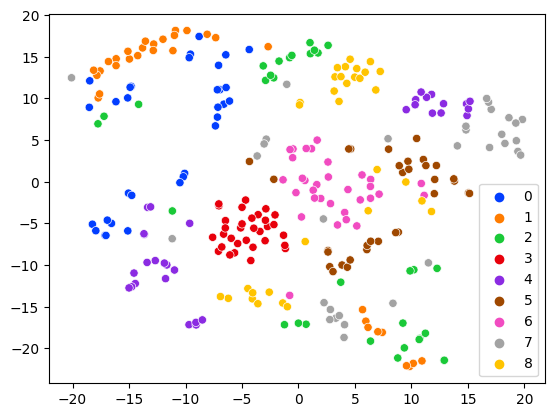

In [181]:
palette = sns.color_palette("bright", 10)
# sns.scatterplot(out)
sns.scatterplot(x=out[:,0], y=out[:,1], hue=h_ids, legend='full', palette=palette)
plt.show()

In [182]:
from sklearn.manifold import TSNE
n_components = 2
model = TSNE(n_components=n_components, perplexity=30)

# 학습한 결과 2차원 공간 값 출력
out2 = model.fit_transform(h2_array)
print(out2.shape)

(288, 2)


/tmp/ipykernel_176030/518851400.py:3: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=out2[:,0], y=out2[:,1], hue=h_ids, legend='full', palette=palette)


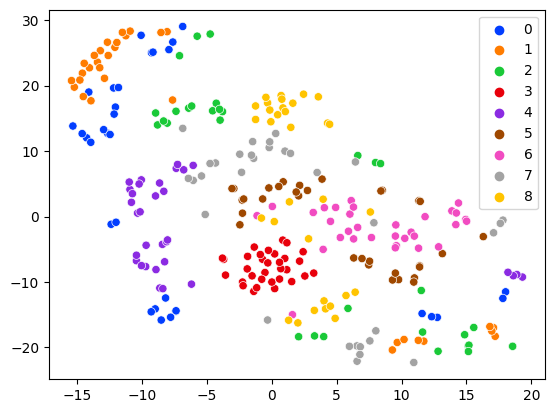

In [183]:
palette = sns.color_palette("bright", 10)
# sns.scatterplot(out)
sns.scatterplot(x=out2[:,0], y=out2[:,1], hue=h_ids, legend='full', palette=palette)
plt.show()

In [18]:
test_envs_returns = dict()
test_envs_lengths = dict()
test_different_envs = []
eval_seed = 3142
for j, env_id in enumerate(env_ids):
    test_envs = make_batched_env(j, env_id, cfg, mode='train')
    test_different_envs.append(test_envs)
    print(f"{j+1}/{len(env_ids)}environment {env_id} is loaded...")
for i, env in enumerate(test_different_envs):
    next_obs = env.reset()
    next_obs = torch.Tensor(next_obs).to(device).view(1, -1)
    done = False
    while not done:
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(env.action_space, next_obs)
        if len(action.shape) > 1:
            action = action.squeeze(0)
            next_obs, reward, truncated, terminated, info = env.step(action.cpu().numpy())
        else:
            next_obs, reward, truncated, terminated, info = env.step(action.cpu().numpy().item())
            
        done = np.logical_or(truncated, terminated)
        next_obs = torch.Tensor(next_obs).to(device).view(1, -1)
        if done:
            print(f"Evaluation. env_name:{env_ids[i]}, episodic_return={info['episode']['r']}")
            test_envs_returns[env_ids[i]+'/eval'] = info["episode"]["r"]
            test_envs_lengths[env_ids[i]+'/eval'] = info["episode"]["l"]


Train env 1: CartPole-v1 is loaded
1/9environment CartPole-v1 is loaded...
Train env 2: Pendulum-v1 is loaded
2/9environment Pendulum-v1 is loaded...
Train env 3: Acrobot-v1 is loaded
3/9environment Acrobot-v1 is loaded...
Train env 4: BipedalWalker-v3 is loaded
4/9environment BipedalWalker-v3 is loaded...
Train env 5: LunarLander-v2 is loaded
5/9environment LunarLander-v2 is loaded...
Train env 6: HalfCheetah-v4 is loaded
6/9environment HalfCheetah-v4 is loaded...
Train env 7: Ant-v4 is loaded
7/9environment Ant-v4 is loaded...
Train env 8: Hopper-v4 is loaded
8/9environment Hopper-v4 is loaded...
Train env 9: Walker2d-v4 is loaded
9/9environment Walker2d-v4 is loaded...


AttributeError: 'int' object has no attribute 'dtype'